<a href="https://colab.research.google.com/github/Himansh-Shah/Video_classification/blob/main/Video_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install remotezip
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.2-py3-none-any.whl size=7890 sha256=cce35cb2d8d149afd8e0d80dfca58fab7d88a869c740a759be8fe88aac7bc880
  Stored in directory: /root/.cache/pip/wheels/f2/71/f9/c650cc34039d772da8b040ed447b6b5f5de9abc38d88073fa1
Successfully built remotezip
  Preparing metadata (setup.py) ... done


In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections
import os
import cv2
import numpy as np
import remotezip as rz
import tensorflow as tf

In [ ]:
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'


In [ ]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files


In [ ]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]


['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [ ]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]


In [ ]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class


In [ ]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50


In [ ]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())


In [ ]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))


Num classes: 101
Num videos for class[0]: 145


In [ ]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset


In [ ]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())


['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

In [ ]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)


In [ ]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder


In [ ]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs


In [ ]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)


train :


100%|██████████| 300/300 [04:37<00:00,  1.08it/s]


val :


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


test :


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


In [ ]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")


Total videos: 500


In [ ]:
import pandas as pd
splits = ["train", "val", "test"]

Video_path = []
Frame_count = []

for items in splits:
  for things in list(download_dir.glob(f"{items}/*/*.avi")):
    Video_path.append(things)
    src = cv2.VideoCapture(str(things))
    Frame_count.append(src.get(cv2.CAP_PROP_FRAME_COUNT))

dataframe = pd.DataFrame({"Video_paths":Video_path,
                          "Frame_size":Frame_count})
dataframe

,Video_paths,Frame_size
0,UCF101_subset/train/BalanceBeam/v_BalanceBeam_...,206.0
1,UCF101_subset/train/BalanceBeam/v_BalanceBeam_...,68.0
2,UCF101_subset/train/BalanceBeam/v_BalanceBeam_...,125.0
3,UCF101_subset/train/BalanceBeam/v_BalanceBeam_...,160.0
4,UCF101_subset/train/BalanceBeam/v_BalanceBeam_...,321.0
...,...,...
495,UCF101_subset/test/BandMarching/v_BandMarching...,139.0
496,UCF101_subset/test/BandMarching/v_BandMarching...,303.0
497,UCF101_subset/test/BandMarching/v_BandMarching...,70.0
498,UCF101_subset/test/BandMarching/v_BandMarching...,145.0


from matplotlib import pyplot as plt
dataframe['Frame_size'].plot(kind='hist', bins=20, title='Frame_size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dataframe['Frame_size'].plot(kind='line', figsize=(8, 4), title='Frame_size')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
!find ./UCF101_subset


./UCF101_subset
./UCF101_subset/train
./UCF101_subset/train/BalanceBeam
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g09_c04.avi
./UCF101_subset/train/BalanceBeam/UCF101
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g10_c04.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g14_c01.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g17_c01.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g11_c02.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g14_c03.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g06_c01.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g17_c03.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g11_c04.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g06_c07.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g22_c02.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g01_c03.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g05_c01.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam_g04_c01.avi
./UCF101_subset/train/BalanceBeam/v_BalanceBeam

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame


In [ ]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result


In [ ]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  24.7M      0  0:00:02  0:00:02 --:--:-- 24.8M


In [ ]:
video_path = "End_of_a_jam.ogv"


In [ ]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape


(10, 224, 224, 3)

In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')



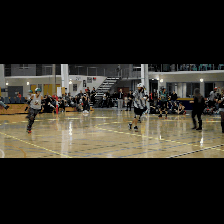

In [ ]:
to_gif(sample_video)



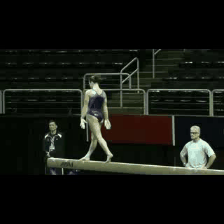

In [ ]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)


In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label


In [ ]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")


Shape: (10, 224, 224, 3)
Label: 6


In [ ]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)


In [ ]:
for frames, labels in train_ds.take(10):
  print(labels)


tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)


In [ ]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)


In [ ]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')


Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)


In [ ]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')


Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


In [ ]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds,
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
150/150 [==============================] - 27s 88ms/step - loss: 1.1501 - accuracy: 0.7267 - val_loss: 0.4978 - val_accuracy: 0.9200
Epoch 2/10
150/150 [==============================] - 9s 57ms/step - loss: 0.3268 - accuracy: 0.9767 - val_loss: 0.2964 - val_accuracy: 0.9600
Epoch 3/10
150/150 [==============================] - 9s 57ms/step - loss: 0.1743 - accuracy: 0.9900 - val_loss: 0.2461 - val_accuracy: 0.9400
Epoch 4/10
150/150 [==============================] - 8s 56ms/step - loss: 0.1125 - accuracy: 0.9967 - val_loss: 0.2085 - val_accuracy: 0.9600
Epoch 5/10
150/150 [==============================] - 9s 60ms/step - loss: 0.0799 - accuracy: 0.9967 - val_loss: 0.1909 - val_accuracy: 0.9600
Epoch 6/10
150/150 [==============================] - 9s 59ms/step - loss: 0.0588 - accuracy: 0.9967 - val_loss: 0.1774 - val_accuracy: 0.9600
Epoch 7/10
150/150 [==============================] - 9s 57ms/step - loss: 0